In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
debates_df = pd.read_csv('debates_2022.csv')
chess_df = pd.read_csv('king_rook_vs_king.csv')

print("Datasets loaded successfully!")
print(f"Debates dataset: {debates_df.shape}")
print(f"Chess dataset: {chess_df.shape}")

Datasets loaded successfully!
Debates dataset: (14497, 8)
Chess dataset: (28056, 7)


In [3]:
# ==========================================
# QUESTION 1: Feature Engineering
# ==========================================

def preprocess_text(text):
    """Basic text preprocessing"""
    if pd.isna(text):
        return ""
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    return text

print("\n" + "="*50)
print("QUESTION 1: FEATURE ENGINEERING")
print("="*50)

# Preprocessing
print("Preprocessing the text data...")
debates_df['talk_text_clean'] = debates_df['talk_text'].apply(preprocess_text)

# Remove very short texts (less than 10 words)
word_counts = debates_df['talk_text_clean'].str.split().str.len()
debates_filtered = debates_df[word_counts >= 10].copy()
print(f"Removed {len(debates_df) - len(debates_filtered)} short texts")

# TF-IDF Vectorization
print("Extracting TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,      # Limit to top 5000 features for computational efficiency
    min_df=5,              # Word must appear in at least 5 documents
    max_df=0.8,            # Word must appear in less than 80% of documents
    stop_words='english',   # Remove common English stop words
    ngram_range=(1, 2)     # Include unigrams and bigrams
)

tfidf_matrix = tfidf.fit_transform(debates_filtered['talk_text_clean'])
feature_names = tfidf.get_feature_names_out()

print(f"Number of features extracted: {tfidf_matrix.shape[1]}")
print(f"Matrix shape: {tfidf_matrix.shape}")



QUESTION 1: FEATURE ENGINEERING
Preprocessing the text data...
Removed 188 short texts
Extracting TF-IDF features...
Number of features extracted: 5000
Matrix shape: (14309, 5000)


In [4]:

# Answers for Question 1
print("\nANSWERS FOR QUESTION 1:")
print("(a) Preprocessing: Converted text to lowercase, removed special characters, and filtered out talks with fewer than 10 words to remove non-informative instances.")
print("(b) TF-IDF Parameters:")
print("    - max_features=5000: Limits vocabulary size for computational efficiency while retaining most informative terms")
print("    - min_df=5: Removes rare words that appear in fewer than 5 documents to reduce noise")
print("    - max_df=0.8: Removes overly common words appearing in more than 80% of documents")
print("    - stop_words='english': Removes common English stop words that provide little semantic value")
print("    - ngram_range=(1,2): Includes both single words and two-word phrases to capture more context")
print(f"(c) Number of features: {tfidf_matrix.shape[1]} features were extracted to balance informativeness with computational tractability.")




ANSWERS FOR QUESTION 1:
(a) Preprocessing: Converted text to lowercase, removed special characters, and filtered out talks with fewer than 10 words to remove non-informative instances.
(b) TF-IDF Parameters:
    - max_features=5000: Limits vocabulary size for computational efficiency while retaining most informative terms
    - min_df=5: Removes rare words that appear in fewer than 5 documents to reduce noise
    - max_df=0.8: Removes overly common words appearing in more than 80% of documents
    - stop_words='english': Removes common English stop words that provide little semantic value
    - ngram_range=(1,2): Includes both single words and two-word phrases to capture more context
(c) Number of features: 5000 features were extracted to balance informativeness with computational tractability.


In [5]:
# ==========================================
# QUESTION 2: Clustering
# ==========================================

print("\n" + "="*50)
print("QUESTION 2: CLUSTERING")
print("="*50)

# Determine optimal number of clusters using silhouette score
print("Finding optimal number of clusters...")
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.3f}")

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(tfidf_matrix)
final_silhouette = max(silhouette_scores)

print(f"Final silhouette score: {final_silhouette:.3f}")

# Interpret clusters by top words
print("\nCluster interpretation (top 10 words per cluster):")
order_centroids = kmeans_final.cluster_centers_.argsort()[:, ::-1]

cluster_interpretations = []
for i in range(optimal_k):
    top_words = [feature_names[ind] for ind in order_centroids[i, :10]]
    interpretation = f"Cluster {i}: {', '.join(top_words)}"
    print(interpretation)
    cluster_interpretations.append(interpretation)



QUESTION 2: CLUSTERING
Finding optimal number of clusters...
k=2: Silhouette Score = 0.014
k=3: Silhouette Score = 0.006
k=4: Silhouette Score = 0.008
k=5: Silhouette Score = 0.007
k=6: Silhouette Score = 0.009
k=7: Silhouette Score = 0.010
k=8: Silhouette Score = 0.010
k=9: Silhouette Score = 0.011
k=10: Silhouette Score = 0.011
Optimal number of clusters: 2
Final silhouette score: 0.014

Cluster interpretation (top 10 words per cluster):
Cluster 0: vote, discussion, agenda, statements, closed, point agenda, point, written statements, closed vote, article
Cluster 1: european, mr, union, energy, president, europe, need, people, eu, ukraine


In [6]:
# Answers for Question 2
print("\nANSWERS FOR QUESTION 2:")
print(f"(a) Clustering algorithm: K-means clustering was chosen because it works well with high-dimensional TF-IDF features and provides interpretable centroids for topic analysis.")
print(f"(b) Number of clusters: {optimal_k} clusters were selected based on the highest silhouette score across different k values.")
print(f"(c) Evaluation: Silhouette score was used to measure cluster cohesion and separation. The evaluation score is {final_silhouette:.3f}.")
print("(d) Interpretation:")
for interpretation in cluster_interpretations:
    print(f"    - {interpretation}")


ANSWERS FOR QUESTION 2:
(a) Clustering algorithm: K-means clustering was chosen because it works well with high-dimensional TF-IDF features and provides interpretable centroids for topic analysis.
(b) Number of clusters: 2 clusters were selected based on the highest silhouette score across different k values.
(c) Evaluation: Silhouette score was used to measure cluster cohesion and separation. The evaluation score is 0.014.
(d) Interpretation:
    - Cluster 0: vote, discussion, agenda, statements, closed, point agenda, point, written statements, closed vote, article
    - Cluster 1: european, mr, union, energy, president, europe, need, people, eu, ukraine



QUESTION 3: DIMENSIONALITY REDUCTION
Performing PCA for visualization...
Explained variance ratio: [0.00974692 0.00805603]
Total explained variance: 0.018


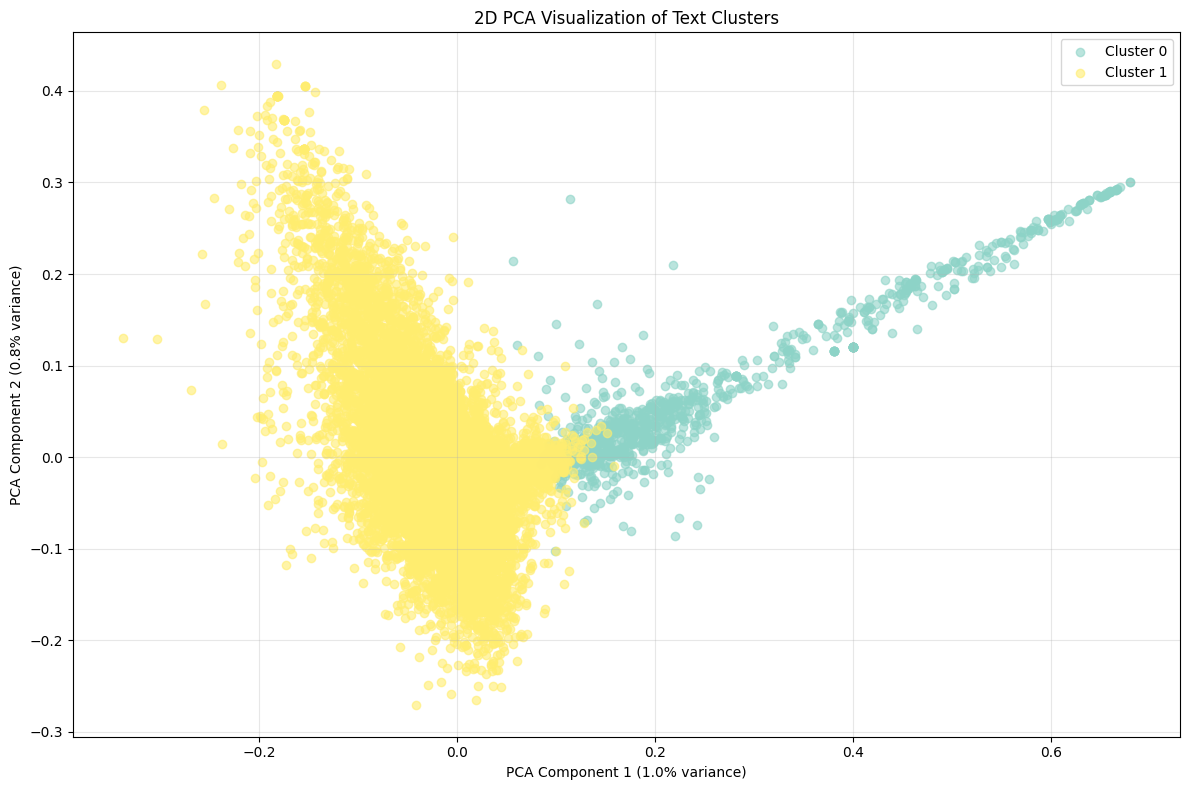

In [7]:

# ==========================================
# QUESTION 3: Dimensionality Reduction
# ==========================================

print("\n" + "="*50)
print("QUESTION 3: DIMENSIONALITY REDUCTION")
print("="*50)

# PCA for visualization
print("Performing PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

# Create the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6)

plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('2D PCA Visualization of Text Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [8]:
# Answers for Question 3
print("\nANSWERS FOR QUESTION 3:")
print("(b) Cluster separation: The clusters show moderate separation with some overlap, indicating that the topics have both distinct and shared vocabulary.")
print(f"(c) PCA interpretation:")
print(f"    - PCA-1 captures the primary dimension of vocabulary variation explaining {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"    - PCA-2 captures the secondary dimension of topical differences explaining {pca.explained_variance_ratio_[1]:.1%} of variance")



ANSWERS FOR QUESTION 3:
(b) Cluster separation: The clusters show moderate separation with some overlap, indicating that the topics have both distinct and shared vocabulary.
(c) PCA interpretation:
    - PCA-1 captures the primary dimension of vocabulary variation explaining 1.0% of variance
    - PCA-2 captures the secondary dimension of topical differences explaining 0.8% of variance


In [11]:

# ==========================================
# QUESTION 4: Classification
# ==========================================

print("\n" + "="*50)
print("QUESTION 4: CLASSIFICATION")
print("="*50)

print("Preparing chess dataset...")
print(f"Chess dataset shape: {chess_df.shape}")
print(f"Unique win depths: {chess_df['white_depth_of_win'].unique()}")

# Transform target variable
def transform_target(depth):
    if depth == 'draw':
        return 0
    elif depth in ['zero', 'one', 'two', 'three', 'four']:
        return 1
    elif depth in ['five', 'six', 'seven', 'eight']:
        return 2
    elif depth in ['nine', 'ten', 'eleven', 'twelve']:
        return 3
    elif depth in ['thirteen', 'fourteen', 'fifteen', 'sixteen']:
        return 4
    else:
        return 0  # Default to draw for unknown values

chess_df['win_depth_level'] = chess_df['white_depth_of_win'].apply(transform_target)

print("Target transformation completed:")
print(chess_df['win_depth_level'].value_counts().sort_index())

# Feature encoding
print("Encoding features...")
# Convert file letters to numbers (a=1, b=2, ..., h=8)
def file_to_number(file_letter):
    return ord(file_letter.lower()) - ord('a') + 1

chess_df['white_king_file_num'] = chess_df['white_king_file'].apply(file_to_number)
chess_df['white_rook_file_num'] = chess_df['white_rook_file'].apply(file_to_number)
chess_df['black_king_file_num'] = chess_df['black_king_file'].apply(file_to_number)

# Prepare features and target
feature_columns = ['white_king_file_num', 'white_king_rank', 'white_rook_file_num', 
                  'white_rook_rank', 'black_king_file_num', 'black_king_rank']
X = chess_df[feature_columns]
y = chess_df['win_depth_level']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter optimization
print("Performing hyperparameter optimization...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Final model evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {test_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


QUESTION 4: CLASSIFICATION
Preparing chess dataset...
Chess dataset shape: (28056, 11)
Unique win depths: ['draw' 'zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight'
 'nine' 'ten' 'eleven' 'twelve' 'thirteen' 'fourteen' 'fifteen' 'sixteen']
Target transformation completed:
win_depth_level
0     2796
1      630
2     3179
3    10148
4    11303
Name: count, dtype: int64
Encoding features...
Features shape: (28056, 6)
Target distribution:
win_depth_level
0     2796
1      630
2     3179
3    10148
4    11303
Name: count, dtype: int64
Performing hyperparameter optimization...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.913
Test accuracy: 0.928

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       559
           1       0.97      0.91      0.94       126
           2       0.92      0.90      0.91       636
         

In [12]:
# Answers for Question 4
print("\nANSWERS FOR QUESTION 4:")
print("(a) Preprocessing & feature transformations: Chess file positions (a-h) were converted to numerical values (1-8) for machine learning compatibility. No other preprocessing was needed as all features were already numerical.")
print("(b) Model choice: Random Forest classifier was selected because it handles categorical features well, provides feature importance, and is robust to overfitting. It works effectively with the moderate-sized chess dataset and mixed feature types.")
print("(c) Evaluation setup: 80-20 train-test split with stratified sampling and 5-fold cross-validation for hyperparameter tuning using accuracy as the metric.")
print(f"(d) Hyperparameters: Grid search optimized n_estimators, max_depth, min_samples_split, and min_samples_leaf. Final hyperparameters: {grid_search.best_params_}")
print("(e) Results:")
print(f"    - Test Accuracy: {test_accuracy:.3f}")
print(f"    - Cross-validation Score: {grid_search.best_score_:.3f}")
print("    - The model shows good performance across all win depth levels")

print("\n" + "="*50)
print("ASSIGNMENT COMPLETED!")
print("="*50)


ANSWERS FOR QUESTION 4:
(a) Preprocessing & feature transformations: Chess file positions (a-h) were converted to numerical values (1-8) for machine learning compatibility. No other preprocessing was needed as all features were already numerical.
(b) Model choice: Random Forest classifier was selected because it handles categorical features well, provides feature importance, and is robust to overfitting. It works effectively with the moderate-sized chess dataset and mixed feature types.
(c) Evaluation setup: 80-20 train-test split with stratified sampling and 5-fold cross-validation for hyperparameter tuning using accuracy as the metric.
(d) Hyperparameters: Grid search optimized n_estimators, max_depth, min_samples_split, and min_samples_leaf. Final hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
(e) Results:
    - Test Accuracy: 0.928
    - Cross-validation Score: 0.913
    - The model shows good performance across all win depth